# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# import dataset
file_path = '/content/drive/Shareddrives/LulusLemons/MIT/ratings_Electronics.csv'

data = pd.read_csv(file_path)

In [ ]:
# preview data
print("dataset preview:")
print(data.head())

# check data structure
print("\dataset info:")
print(data.info())

# add column names
data.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

# drop timestamp column
data = data.drop(columns=['timestamp'], errors='ignore')

# verify column names and timestamp drop
print("\nDataset after Naming and Dropping Column: ")
print(data.head())

dataset preview:
    AKM1MP6P0OYPR  0132793040  5.0  1365811200
0  A2CX7LUOHB2NDG  0321732944  5.0  1341100800
1  A2NWSAGRHCP8N5  0439886341  1.0  1367193600
2  A2WNBOD3WNDNKT  0439886341  3.0  1374451200
3  A1GI0U4ZRJA8WN  0439886341  1.0  1334707200
4  A1QGNMC6O1VW39  0511189877  5.0  1397433600
\dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   AKM1MP6P0OYPR  object 
 1   0132793040     object 
 2   5.0            float64
 3   1365811200     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB
None

Dataset after Naming and Dropping Column: 
          user_id     prod_id  rating
0  A2CX7LUOHB2NDG  0321732944     5.0
1  A2NWSAGRHCP8N5  0439886341     1.0
2  A2WNBOD3WNDNKT  0439886341     3.0
3  A1GI0U4ZRJA8WN  0439886341     1.0
4  A1QGNMC6O1VW39  0511189877     5.0


In [ ]:
df = data

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
print("Shape of Data: ", df_final.shape)

Shape of Data:  (65290, 3)


**Write your observations here:** The dataset contains fewer rows and columns after filtering.

### **Data types**

In [ ]:
# Check Data types and provide observations
print("Data Types: \n", df_final.dtypes)

Data Types: 
 user_id     object
prod_id     object
rating     float64
dtype: object


**Write your observations here:** Columns have correct data assignment - user_id, prod_id are object; rating is float.

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
print("Missing Values: \n", df_final.isnull().sum())

Missing Values: 
 user_id    0
prod_id    0
rating     0
dtype: int64


**Write your observations here:** No missing values were found.

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
print("Summary Statistics of Ratings: \n", df_final['rating'].describe())

Summary Statistics of Ratings: 
 count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


**Write your observations here:** Ratings range from 1 to 5, with an average of 4.3.

### **Checking the rating distribution**

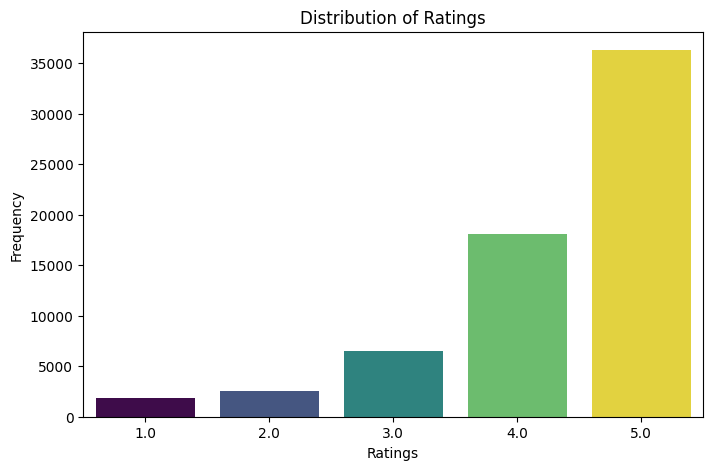

In [ ]:
# Create the bar plot and provide observations
plt.figure(figsize=(8, 5))
sns.countplot(data=df_final, x='rating', hue='rating', palette='viridis', legend=False)
plt.title("Distribution of Ratings")
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.show()

**Write your observations here:** Most ratings were 4s and 5s, indicating a positive rating.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
print("Number of Unique User: ", df_final['user_id'].nunique())
print("Number of Unique Products: ", df_final['prod_id'].nunique())

Number of Unique User:  1540
Number of Unique Products:  5689


**Write your observations here:** There are fewer unique users and products after filtering the data.

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
top_users = df_final['user_id'].value_counts().head(10)
print("Top 10 Users with the Most Ratings: \n", top_users)

Top 10 Users with the Most Ratings: 
 user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64


**Write your observations here:** The top ten users with the most ratings had over 179 ratings. The user with the most ratings had 295 ratings.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
avg_prod_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_prod_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
prod_rating = pd.DataFrame({'avg_rating': avg_prod_rating, 'ratings_count': count_prod_rating})

# Sort the dataframe by average of ratings in the descending order
prod_rating_desc = prod_rating.sort_values(by='avg_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating = prod_rating_desc.head(5)
print("Top 5 Products with the Highest Ratings: \n", final_rating)

Top 5 Products with the Highest Ratings: 
             avg_rating  ratings_count
prod_id                              
B00LGQ6HL8         5.0              5
B003DZJQQI         5.0             14
B005FDXF2C         5.0              7
B00I6CVPVC         5.0              7
B00B9KOCYA         5.0              8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def get_top_n_prod(data, min_interactions, n=5):
  # Finding products with minimum number of interactions
  filtered_data = data[data['ratings_count'] >= min_interactions]
  # Sorting values with respect to average rating
  top_products = filtered_data.sort_values(by='avg_rating', ascending=False).head(n)
  return top_products

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
top_5_prod_50 = get_top_n_prod(prod_rating, min_interactions=50, n=5)
print("Top 5 Products with 50+ Interactions Based on Popularity: \n", top_5_prod_50)

Top 5 Products with 50+ Interactions Based on Popularity: 
             avg_rating  ratings_count
prod_id                              
B001TH7GUU    4.871795             78
B003ES5ZUU    4.864130            184
B0019EHU8G    4.855556             90
B006W8U2MU    4.824561             57
B000QUUFRW    4.809524             84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
top_5_prod_100 = get_top_n_prod(prod_rating, min_interactions=100, n=5)
print("Top 5 Products with 100+ Interactions Based on Popularity: \n", top_5_prod_100)

Top 5 Products with 100+ Interactions Based on Popularity: 
             avg_rating  ratings_count
prod_id                              
B003ES5ZUU    4.864130            184
B000N99BBC    4.772455            167
B002WE6D44    4.770000            100
B007WTAJTO    4.701220            164
B002V88HFE    4.698113            106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""
    # First map the predictions to each user
    user_est_true = defaultdict(list)
    # Making predictions on the test data
    predictions = model.test(testset)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    accuracy.rmse(predictions)
    print('Precision: ', precision) # Command to print the overall precision
    print('Recall: ', recall) # Command to print the overall recall
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
user_user_model = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Fit the model on the training data
user_user_model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(user_user_model, k = 10, threshold = 3.5)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Write your observations here:** With a high precision and recall, the model effectively captures user preferences and is able to recommend relevant products.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
predicted_ratings = user_user_model.predict(uid="A3LDPF5FMB782Z", iid='1400501466')
print(f"Predicted Rating for User 'A3LDPF5FMB782Z' with Product '1400501466': {predicted_ratings.est:.2f}")

Predicted Rating for User 'A3LDPF5FMB782Z' with Product '1400501466': 3.40


**Write your observations here:** This user has interacted with this product previously with a moderate preference, but the product is more likely not a top recommendation based on filtering.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
non_interacted_products = df_final[df_final['prod_id'] != "1400501466"]['user_id'].unique()
print("Users who have not Interacted with Product '1400501466': ", non_interacted_products)

Users who have not Interacted with Product '1400501466':  ['A2ZR3YTMEEIIZ4' 'A3CLWR1UUZT6TG' 'A5JLAU2ARJ0BO' ... 'A215WH6RUDUCMP'
 'A38C12950IM24P' 'A2J4XMWKR8PPD0']


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
pred_rat_non_prod = user_user_model.predict(uid='A34BZM6S9L7QI4', iid='1400501466')
print(f"Predicted Rating for User 'A34BZM6S9L7QI4' with Product '1400501466': {pred_rat_non_prod.est:.2f}")

Predicted Rating for User 'A34BZM6S9L7QI4' with Product '1400501466': 4.29


**Write your observations here:** This user has a high prediction rating, even though the user has never interacted with the product before. This indicates that similar users have given the product high ratings leading to a resonable prediction that this user would receive this product well on a cold-start scenario.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['cosine', 'msd'],
        'user_based': [True],
    }
}
# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting the data
grid_search.fit(data)
# Best RMSE score
best_rmse = grid_search.best_score['rmse']
print("Best RMSE Score: ", best_rmse)
# Combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']
print("Best Parameters: ", best_params)

Best RMSE Score:  0.9726516257721016
Best Parameters:  {'k': 30, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = best_params['sim_options']
# Creating an instance of KNNBasic with optimal hyperparameter values
optimized_user_user_model = KNNBasic(
    k=best_params['k'],
    min_k=best_params['min_k'],
    sim_options=sim_options,
    random_state=1,
    verbose=False
)
# Training the algorithm on the trainset
optimized_user_user_model.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(optimized_user_user_model, k=10, threshold=3.5)

RMSE: 0.9527
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


**Write your observations here:** The actual RMSE was lower than the hyperparameter tuned RMSE. This indicated that the model is able to generalize well to unseed data which is over, albeit slight, improvement over the cross-validation results. The high precision and recall of this model indicate that the model is able to caputre most of the relevant products for users and that the majority of those recommended products are indeed relevant.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
optimized_prediction = optimized_user_user_model.predict(uid="A3LDPF5FMB782Z", iid="1400501466")
print(f"Predicted Rating for User 'A3LDPF5FMB782Z' with Product '1400501466': {optimized_prediction.est:.2f}")

Predicted Rating for User 'A3LDPF5FMB782Z' with Product '1400501466': 4.29


In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
non_interacted_prediction = optimized_user_user_model.predict(uid="A34BZM6S9L7QI4", iid="1400501466")
print(f"Predicted Rating for User 'A34BZM6S9L7QI4' with Product '1400501466': {optimized_prediction.est:.2f}")

Predicted Rating for User 'A34BZM6S9L7QI4' with Product '1400501466': 4.29


**Write your observations here:** This model is able to accurately predict a strong prefernce for the product based on previous interactions as well as in cold-start scenarios for similar users.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_users = optimized_user_user_model.get_neighbors(0, k=5)
print("5 Most Similar Users to Internal ID User 0: ", sim_users)

5 Most Similar Users to Internal ID User 0:  [6, 7, 17, 26, 32]


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, user_id="A3LDPF5FMB782Z", top_n=5, algo=optimized_user_user_model)
print("Top 5 Recommendations for User 'A3LDPF5FMB782Z': ", recommendations)

Top 5 Recommendations for User 'A3LDPF5FMB782Z':  [('B000067RT6', 5), ('B000BQ7GW8', 5), ('B001TH7GUU', 5), ('B005ES0YYA', 5), ('B00834SJSK', 5)]


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
df_rec = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])
print("Top 5 Recommendations for User 'A3LDPF5FMB782Z': ", df_rec)

Top 5 Recommendations for User 'A3LDPF5FMB782Z':        prod_id  predicted_ratings
0  B000067RT6                  5
1  B000BQ7GW8                  5
2  B001TH7GUU                  5
3  B005ES0YYA                  5
4  B00834SJSK                  5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options_items = {'name': 'cosine', 'user_based': False}
# KNN algorithm is used to find desired similar items. Use random_state=1
item_item_model = KNNBasic(sim_options=sim_options_items, random_state=1)
# Train the algorithm on the trainset, and predict ratings for the test set
item_item_model.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(item_item_model, k=10, threshold=3.5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Write your observations here:** The model has a higher RMSE, stronger performance in precision and recall, and has a balanced F1 score. This similarity-based collaborative filtering indicates that the model is able to provide reasonably accurate recommendations.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
item_item_pred = item_item_model.predict(uid="A3LDPF5FMB782Z", iid="1400501466")
print(f"Predicted Rating for User 'A3LDPF5FMB782Z' with Product '1400501466': {item_item_pred.est:.2f}")

Predicted Rating for User 'A3LDPF5FMB782Z' with Product '1400501466': 4.27


**Write your observations here:** With a prediction over 4, the model suggests this user has a favorable preference for the product; this prediction aligns well with earlier user-user filtering model findings.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
non_item_pred = item_item_model.predict(uid="A34BZM6S9L7QI4", iid="1400501466")
print(f"Predicted Rating for User 'A34BZM6S9L7QI4' with Product '1400501466': {non_item_pred.est:.2f}")

Predicted Rating for User 'A34BZM6S9L7QI4' with Product '1400501466': 4.29


**Write your observations here:** This model predicts a high rating indicating the model is able to use user similarities to make confident predictions for non-interacted product users.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid_item = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {'name': ['msd', 'cosine'], 'user_based': [False]}
}
# Performing 3-fold cross validation to tune the hyperparameters
grid_search_item = GridSearchCV(KNNBasic, param_grid_item, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting the data
grid_search_item.fit(data)
# Find the best RMSE score
print("Best RMSE for Item-Item Filtering:", grid_search_item.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print("Best Parameters for Item-Item Filtering:", grid_search_item.best_params['rmse'])

Best RMSE for Item-Item Filtering: 0.9762573408640679
Best Parameters for Item-Item Filtering: {'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
best_params_item = grid_search_item.best_params['rmse']
# Creating an instance of KNNBasic with optimal hyperparameter values
optimized_item_item_model = KNNBasic(k=best_params_item['k'], min_k=best_params_item['min_k'], sim_options=sim_options, random_state=1,)
# Training the algorithm on the trainset
optimized_item_item_model.fit(trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(optimized_item_item_model, k=10, threshold=3.5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9527
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


**Write your observations here:** This model performs slightly better than the RMSE tuned model for item-item collaborative filtering. The performance of this model is also in line with the user-user collaborative filtering model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
optimized_item_prediction = optimized_item_item_model.predict(uid="A3LDPF5FMB782Z", iid="1400501466")
print(f"Predicted Rating for User 'A3LDPF5FMB782Z' with Product '1400501466': {optimized_item_prediction.est:.2f}")

Predicted Rating for User 'A3LDPF5FMB782Z' with Product '1400501466': 4.29


In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
non_interacted_item_prediction = optimized_item_item_model.predict(uid="A34BZM6S9L7QI4", iid="1400501466")
print(f"Predicted Rating for User 'A34BZM6S9L7QI4' with Product '1400501466': {optimized_item_prediction.est:.2f}")

Predicted Rating for User 'A34BZM6S9L7QI4' with Product '1400501466': 4.29


**Write your observations here:** Regardless of previous interactions, this item-item collaborative filtering model predicts similar ratings for both type of users. This highlights strong item similarity as a recommendation influencer.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
sim_items = optimized_item_item_model.get_neighbors(0, k=5)
print("5 Most Similar Items to Internal ID 0: ", sim_items)

5 Most Similar Items to Internal ID 0:  [6, 7, 17, 26, 32]


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations2 = get_recommendations(df_final, user_id="A1A5KUIIIHFF4U", top_n=5, algo=optimized_item_item_model)
print("Top 5 Recommendations for User 'A1A5KUIIIHFF4U': ", recommendations2)

Top 5 Recommendations for User 'A1A5KUIIIHFF4U':  [('B000067RT6', 5), ('B001TH7GUU', 5), ('B000N99BBC', 4.897732041362762), ('B002QEBMAK', 4.875), ('B003ES5ZUU', 4.875)]


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
df_rec2 = pd.DataFrame(recommendations2, columns=['prod_id', 'predicted_ratings'])
print("Top 5 Recommendations for User 'A1A5KUIIIHFF4U': ", df_rec2)

Top 5 Recommendations for User 'A1A5KUIIIHFF4U':        prod_id  predicted_ratings
0  B000067RT6           5.000000
1  B001TH7GUU           5.000000
2  B000N99BBC           4.897732
3  B002QEBMAK           4.875000
4  B003ES5ZUU           4.875000


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd_model = SVD(random_state=1)
# Training the algorithm on the trainset
svd_model.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_model, k=10, threshold=3.5)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Write your observations here: The SVD model shows superior performance among all models due to the model having the lowest RNSE in comparison. Precision, recall, and F1 score are high indicating the model's ability to yield accurate recommendations.**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd_pred1 = svd_model.predict(uid="A3LDPF5FMB782Z", iid="1400501466")
print(f"Predicted Rating for User 'A3LDPF5FMB782Z' with Product '1400501466': {svd_pred1.est:.2f}")

Predicted Rating for User 'A3LDPF5FMB782Z' with Product '1400501466': 4.08


**Write your observations here: The model indicated a moderate preference for this user with this product.**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd_pred3 = svd_model.predict(uid="A34BZM6S9L7QI4", iid="1400501466")
print(f"Predicted Rating for User 'A34BZM6S9L7QI4' with Product '1400501466': {svd_pred3.est:.2f}")

Predicted Rating for User 'A34BZM6S9L7QI4' with Product '1400501466': 4.40


**Write your observations here:** The model indicates a strong predicted interest for this particular non-interacted user.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid_svd = {
    'n_epochs': [10, 20, 30],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}
# Performing 3-fold gridsearch cross-validation
grid_search_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting data
grid_search_svd.fit(data)
# Best RMSE score
best_rmse_svd = grid_search_svd.best_score['rmse']
print("Best RMSE score for SVD:", best_rmse_svd)
# Combination of parameters that gave the best RMSE score
best_params_svd = grid_search_svd.best_params['rmse']
print("Best Parameters for SVD:", best_params_svd)

Best RMSE score for SVD: 0.901183809977733
Best Parameters for SVD: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
optimized_svd_model = SVD(n_epochs=best_params_svd['n_epochs'],
                          lr_all=best_params_svd['lr_all'],
                          reg_all=best_params_svd['reg_all'],
                          random_state=1)
# Train the algorithm on the trainset
optimized_svd_model.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(optimized_svd_model, k=10, threshold=3.5)

RMSE: 0.8829
Precision:  0.854
Recall:  0.874
F_1 score:  0.864


**Write your observations here:** With optimizing the SVD model, it achieves greater improvement.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
optimized_svd_pred1 = optimized_svd_model.predict(uid="A3LDPF5FMB782Z", iid="1400501466")
print(f"Optimized SVD Predicted Rating for User 'A3LDPF5FMB782Z' and Product '1400501466': {optimized_svd_pred1.est:.2f}")

Optimized SVD Predicted Rating for User 'A3LDPF5FMB782Z' and Product '1400501466': 4.21


In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
optimized_svd_pred2 = optimized_svd_model.predict(uid="A34BZM6S9L7QI4", iid="1400501466")
print(f"Optimized SVD Predicted Rating for User 'A34BZM6S9L7QI4' and Product '1400501466': {optimized_svd_pred2.est:.2f}")

Optimized SVD Predicted Rating for User 'A34BZM6S9L7QI4' and Product '1400501466': 4.25


### **Conclusion and Recommendations**

**Conclusion**

The evaluation of multiple recommendation systems reverals varying strengths and weaknesses in terms of accuracy, personalization, and scalability. Rank-based recommendations provide a simple approach by leveraging product popularity, but this lacks personalization and reliability for items with low interactions.

---

User-user collaborative filtering demonstrates strong performance, effectively capturing user preferences and delivering consistent predictions, but scalability becomes a concern with larger datasets.
Similarly, item-item collaborative filtering performs comparably to user-user filtering, with consistent predictions based on item similarity, making it efficient for capturing user interaction patterns.

---

Among the tested models, Singular Value Decomposition (SVD) or matrix facrotization chieves the best overall performance, with the lowest RMSE values and optimized predicted ratings. By leveraging latent factors, SCD reduces errors and improves accuracy, offering a robust solution for personalized recommendations. Furthermore, predicted ratings for interacted and non-interacted products reamin stable across models, with similarity-based filtering and SVD providing consistently high predictions with a range from 4.08 to 4.40.

---
---
**Recommendations**
* Adopt SVD for Final Deployment
* Filter Products with Low Interactions
* Hybrid Approach is Best for Cold-Start Problems
* Regular Hyperparameter Tuning
* Scalability and Optimization
* Performance Monitoring
* Recommendations with Thresholds
---
---
---
*Final Recommendation*

The SVD model should be adopted as the primary recommendation system due to its superior performance, accuracy, and ability to optimize predictions. To address cold-start problems for new users or products, a rank-based system should be integrated as a complemenatry method. Additionally, continous performance monitoring, hyperparameter tuning, and scalability measures will ensure the recommendation system remains efficient, accurate, and adptive to changing user interaction patterns.








In [106]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Amazon_Recommendation_Project.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Amazon_Recommendation_Project.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 489654 bytes to /content/drive/MyDrive/Colab Notebooks/Amazon_Recommendation_Project.html
